<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

### Qbit Pi Rotation 

Generator configuration 

Set SCLK – 8666MSas 

Define segment 2 length – 448 points 

Download waveform (Pi Pulse) – 4 point per cycle Sine wave with a Gaussian shape envelope. 

Create a task table of 1 lines: 

Task 1 		Enable Signal = 	CPU 

DTrigger  = 	ON 

Next Task 1 = 	end 

Download Task Table 

Enable Task Mode 

 

Digitizer Configuration 

Set SCLK – 2700MHz 

Set DDC mode to complex 

Set center frequency of channel 1 to 200MHz 

Define Frame configuration –	Number of frames = 1 

Frame size = 144 points 

Set Trigger Source to TASK1 

Set Trigger AWG delay  

Set capture frames to all 

 

 

DSP Configuration 

Select to store the IQ data 

Set IQ PATH Input to AMPH 

Set Decision frame size 50 points 

 

 

Create a loop that changes the amplitude of the output by 1mV, triggers the task table, polls the digitizer that the capture is done, erases the frame data and then repeats.  

In [1]:
import os
import sys
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

In [2]:
#matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt
from scipy import signal
import math

In [23]:
#Set all parameters for experiment
SCLK = 9000e6
DIG_SCLK = 2700e6
CH_NMB = 1
SEG_NMB = 1
#FRAME_NUM = 1
GAUS_FC = 5.98
GAUS_LEN = 448
DUC_NCO = 1040e6 #MHz
DDC_NCO = 240e6
DUC_INTERP = 8
numframes = 10
Frame_len = 864
Debug = False

In [4]:
# Connect to instrument
admin = TepAdmin()
    
# Get list of available PXI slots
slot_ids = admin.get_slot_ids()

# Assume that at least one slot was found
sid = slot_ids[0]

 # Open a single-slot instrument:
inst = admin.open_instrument(slot_id=sid)

# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print('Connected to: ' + resp)

# Get the model name
resp = inst.send_scpi_query(":SYST:iNF:MODel?")
print("Model: " + resp)

# Infer the natural DAC waveform format
if 'P9082' in resp:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

Connected to: Tabor Electronics,P9484M,000002210203,1.200.0
Model: P9484M
DAC waveform format: 16 bits-per-point


In [6]:
# Several initializations ..

inst.default_paranoia_level = 2

#Reset instrument
inst.send_scpi_cmd('*CLS; *RST')

#Configure Interpolation and DUC Mode for instrument. Note this will effect the DAC mode.
inst.send_scpi_cmd(':MODE DUC')
inst.send_scpi_cmd(':INT x{0}' .format(DUC_INTERP))
inst.send_scpi_cmd(':IQM ONE')
inst.send_scpi_cmd(':NCO:CFR1 {0}' .format(DUC_NCO))
#Enable sixdB gain in DUC mode
inst.send_scpi_cmd(':NCO:SIXD1 ON')

inst.send_scpi_cmd(':INST:CHAN 2')
inst.send_scpi_cmd(':INIT:CONT ON')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
inst.send_scpi_cmd(':FREQ:RAST {0}'.format(SCLK))

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


gaussian fc 30.033482142857146Mhz


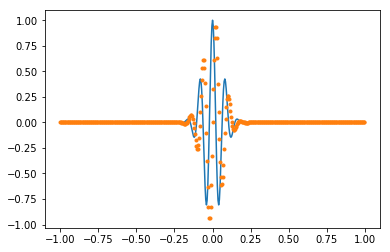

In [7]:
# gaussian wave form 
t = np.linspace(-1, 1, GAUS_LEN, endpoint=False)

i, q, e = signal.gausspulse(t, 2*GAUS_FC, retquad=True, retenv=True)
gaussian_e = (e)
gaussian_i = (i)
gaussian_q = (q)
print('gaussian fc {0}Mhz'.format(SCLK * 2 * GAUS_FC / GAUS_LEN / 1e6/ DUC_INTERP))
plt.plot(t, gaussian_i, '-',t, gaussian_q, '.')


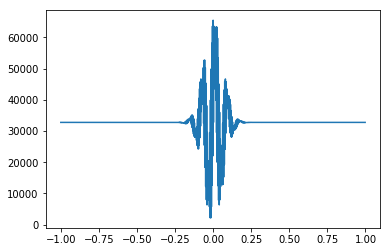

In [8]:
wave = list(range(2*GAUS_LEN))
tp = np.linspace(-1, 1, 2*GAUS_LEN, endpoint=False)

wave[::2]=gaussian_i
wave[1::2]=gaussian_q

wave = [x*half_dac for x in wave]
wave = [x + half_dac for x in wave]
wave = np.round(wave)
wave = np.clip(wave, 0, max_dac)


if dac_mode == 16:
    wave = wave.astype(np.uint16)
else:
    wave = wave.astype(np.uint8)

#print(wave)
plt.plot(tp, wave, '-')


# Create and download waveforms 

In [9]:

# download it to segment 1 of channel 1
inst.send_scpi_cmd(':INST:CHAN {0}'.format(CH_NMB))
inst.send_scpi_cmd(':TRAC:DEF {0},'.format(SEG_NMB) + str(wave.size))
inst.send_scpi_cmd(':TRAC:SEL {0}'.format(SEG_NMB))

print('wave size: {0}'.format(wave.size))
# download the waveform to the selected segment
inst.write_binary_data(':TRAC:DATA', wave)

inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM 1')
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
inst.send_scpi_cmd(':OUTP ON')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

wave size: 896
0, no error


## Reading the data

0, no error


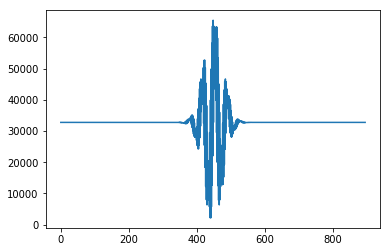

In [10]:
offset_in_bytes = 0


if dac_mode == 16:
    size_in_bytes = wave.size * 2
else:
    size_in_bytes = wave.size
    
data_type = np.uint16 if dac_mode == 16 else np.uint8


# Select channel
cmd = ':INST:CHAN {0}'.format(CH_NMB)
inst.send_scpi_cmd(cmd)
    
# Select segment
cmd = ':TRAC:SEL {0}'.format(SEG_NMB)
inst.send_scpi_cmd(cmd)

# Allocate buffer
rd_wav = np.empty(wave.size, dtype=data_type)
    
# Read binary data
cmd = ':TRAC:DATA? {0}, {1}'.format(offset_in_bytes, size_in_bytes)

inst.read_binary_data(
        scpi_pref=cmd,
        out_array=rd_wav,
        num_bytes=size_in_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Plot the waves
xr = np.arange(wave.size)
plt.plot(xr, rd_wav)

plt.show()
del xr, rd_wav

# Create and download Task table

In [11]:
tasklen = 1

#Select channel
cmd = ':INST:CHAN {0}'.format(CH_NMB)
inst.send_scpi_cmd(cmd )

cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
inst.send_scpi_cmd(cmd )



for i in range(tasklen):
    curr_task = i+1
    cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
    inst.send_scpi_cmd(cmd)
    cmd = ':TASK:COMP:DTRigger ON'        
    inst.send_scpi_cmd(cmd)
 
    if curr_task == 1:  
        cmd = ':TASK:COMP:ENAB CPU'
        inst.send_scpi_cmd(cmd)

    if curr_task==tasklen:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
        inst.send_scpi_cmd(cmd)
    else:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
        inst.send_scpi_cmd(cmd )    

    cmd = ':TASK:COMP:TYPE SING'
    inst.send_scpi_cmd(cmd )

    
    cmd = ':TASK:COMP:LOOP {0}'.format(1)
    inst.send_scpi_cmd(cmd )

    cmd = ':TASK:COMP:SEGM {0}'.format(1)
    inst.send_scpi_cmd(cmd )

    
cmd = ':TASK:COMP:WRIT'
inst.send_scpi_cmd(cmd)
print('Downloading Task table to channel {0}'.format(CH_NMB))

cmd = ':INST:CHAN {0}'.format(CH_NMB)
inst.send_scpi_cmd(cmd)
    
cmd = ':OUTP ON'
inst.send_scpi_cmd(cmd)

cmd = ':FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


0, no error


## Setup Digitizer

In [24]:
# Setup the digitizer in two-channels mode
inst.send_scpi_cmd(':DIG:MODE DUAL')
inst.send_scpi_cmd(':DIG:CHAN:RANG LOW')

# Set SCLK digitizer 
inst.send_scpi_cmd(':DIG:FREQ {0}'.format(DIG_SCLK))

# Set DDC mode to complex
inst.send_scpi_cmd(':DIG:DDC:MODE COMPlex')

# Set center frequency of channel 1 to 200MHz
inst.send_scpi_cmd(':DIG:DDC:CFR1 {0}'.format(DDC_NCO))

# Allocate 1000 frames of 864 samples
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, Frame_len)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
capture_first, capture_count = 1, numframes
cmd = ":DIG:ACQuire:FRAM:CAPT {0},{1}".format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')

# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')

# Set Trigger AWG delay to 0
inst.send_scpi_cmd(':DIG:TRIG:DEL {0}'.format(1))

# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("Set Digitizer: DUAL mode; ADC Trigger")

resp = inst.send_scpi_query(':DIG:DDC:DEC?')
print(resp)

0, no error
Set Digitizer: DUAL mode; ADC Trigger
X16


## Setup DSP

In [25]:
# Select to store the IQ data
inst.send_scpi_cmd(':DSP:STOR1 DIRect1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Set IQ PATH Input to AMPH
inst.send_scpi_cmd(':DSP:DEC:IQP:SEL 1')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
inst.send_scpi_cmd(':DSP:DEC:IQP:INP AMPH')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
# Set Decision frame size 50 points
inst.send_scpi_cmd(':DSP:DEC:FRAM {0}'.format(50))
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error
0, no error
0, no error
0, no error


## Acquire signals into Memory

In [26]:
#Number of pulses to be generated
num_of_pulses = numframes
#Resolution of amplitude change of DAC in mV. Minimum is 1mV. DAC amplitude 1mV<=amp<=550mV
amplitude_res = 20

amp = 550

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')
    
# Start the digitizer's capturing machine
inst.send_scpi_cmd(':DIG:INIT ON')

print("Press enter to generate trigger - press Enter to start experiment")
input()

for i in range(num_of_pulses):
        
    if i>= 1:
        inst.send_scpi_cmd(':VOLT {0}' .format((amp-amplitude_res)*0.001))
        amp = amp-amplitude_res
    else:
        inst.send_scpi_cmd(':VOLT {0}' .format((amp)*0.001))
            
    resp = inst.send_scpi_query(':VOLT?')
    print(resp)
    inst.send_scpi_cmd('*TRG')
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)
    time.sleep(1)
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STAT?')
    print('captured {0} frames'.format(resp[6:]))
    

print('Capture done. Captured {0} frames'.format(resp[6:]))


Press enter to generate trigger - press Enter to start experiment

0.55
0, no error
captured 1 frames
0.53
0, no error
captured 2 frames
0.51
0, no error
captured 3 frames
0.49
0, no error
captured 4 frames
0.47
0, no error
captured 5 frames
0.45
0, no error
captured 6 frames
0.43
0, no error
captured 7 frames
0.41
0, no error
captured 8 frames
0.39
0, no error
captured 9 frames
0.37
0, no error
captured 10 frames
Capture done. Captured 10 frames


## Read all frames from Memory

In [27]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint32)


rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("read data from DDR")


Total size in bytes: 17280

0, no error
read data from DDR


## Plot Signals  - captured waveforms

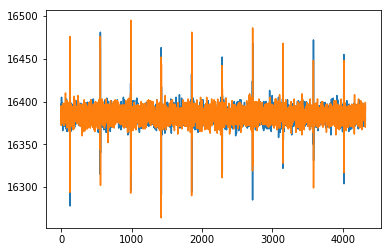

In [28]:
# Plot the samples
totlen = int(numframes * Frame_len /2)
x = range(totlen)

wave_i = np.zeros(totlen, dtype=np.uint16)
wave_q = np.zeros(totlen, dtype=np.uint16)

wave_i = wav1[::2]
wave_q = wav1[1::2]

plt.plot(x, wave_i, '-',x, wave_q, '-')

# Read all frame Headers from Memory

In [29]:
inst.send_scpi_cmd(':DIG:DATA:TYPE HEAD')
header_size=72
number_of_frames = numframes
num_bytes = number_of_frames * header_size
print('Total Headers size in bytes: {0} '.format(num_bytes))

wav2 = np.zeros(num_bytes, dtype=np.uint8)
rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print("read data from DDR")


#print(wav2)


I_dec= np.zeros(number_of_frames,np.int32)
Q_dec= np.zeros(number_of_frames,np.int64)
for i in range(number_of_frames):
    idx = i* header_size
    trigPos = wav2[idx]
    gateLen = wav2[idx+1]
    minVpp = wav2[idx+2] & 0xFFFF
    maxVpp = wav2[idx+2] & 0xFFFF0000 >> 16
    timeStamp = wav2[idx+3] + wav2[idx+4] << 32
    #decisionReal = wav2[idx+5] + (wav2[idx+6] << 32)
    decisionReal = (wav2[idx+20]) + (wav2[idx+21] <<8) + \
                    (wav2[idx+22] << 16) + (wav2[idx+23] <<24) + \
                    (wav2[idx+24] << 32) + (wav2[idx+25] <<40) + \
                    (wav2[idx+26] << 48)+ (wav2[idx+27] << 56)
    Q_dec[i]= decisionReal
    #decisionIm = int(wav2[idx+7])
    decisionIm = (wav2[idx+28]) + (wav2[idx+29] <<8) + \
                    (wav2[idx+30] << 16) + (wav2[idx+31] <<24) 
    I_dec[i]= decisionIm
    outprint = 'header# {0}\n'.format(i)
    outprint += 'TriggerPos: {0}\n'.format(trigPos)
    outprint += 'GateLength: {0}\n'.format(gateLen)
    outprint += 'Min Amp: {0}\n'.format(minVpp)
    outprint += 'Max Amp: {0}\n'.format(maxVpp)
    outprint += 'Min TimeStamp: {0}\n'.format(timeStamp)
    outprint += 'Decision: {0} + j* {1}\n'.format(decisionReal,decisionIm)
    #print(outprint)

Total Headers size in bytes: 720 
0, no error
read data from DDR


# Plot phase and amplitude of decision

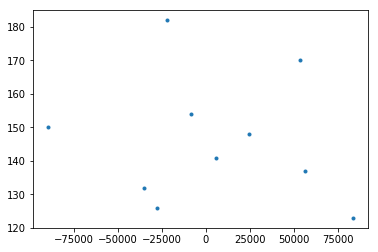

In [30]:
# Plot the samples

plt.plot(I_dec, Q_dec,'.')

## read debug registers

In [ ]:
import tempfile
import webbrowser

if Debug == True :
    channb = 1
    cmd = ':INST:CHAN {0}; :SYST:INF:REG?'.format(channb)
    html_str = inst.send_scpi_query(cmd, max_resp_len=200000)
    #print(html_str)
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html') as f:
        url = 'file://' + f.name
        f.write(html_str)
    webbrowser.open(url)

In [31]:
# close connection
inst.close_instrument()
admin.close_inst_admin()

0

In [ ]:
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd(':NCO:CFR1 1.04e9')
inst.send_scpi_cmd(':NCO:SIXD2 ON')
resp = inst.send_scpi_query(':NCO:SIXD1?')
print(resp)
